# Harringtonine: CropArray - Cellpose

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import trackpy as tp
import pandas as pd
import xarray as xr
# Segmenting using cellpose
from cellpose import models, core
import warnings
warnings.filterwarnings('ignore')
# Importing croparray
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
ca.print_banner()
# %matplotlib inline 
plt.style.use('dark_background')

 
░█████╗░██████╗░░█████╗░██████╗░░█████╗░██████╗░██████╗░░█████╗░██╗░░░██╗
██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗╚██╗░██╔╝
██║░░╚═╝██████╔╝██║░░██║██████╔╝███████║██████╔╝██████╔╝███████║░╚████╔╝░
██║░░██╗██╔══██╗██║░░██║██╔═══╝░██╔══██║██╔══██╗██╔══██╗██╔══██║░░╚██╔╝░░
╚█████╔╝██║░░██║╚█████╔╝██║░░░░░██║░░██║██║░░██║██║░░██║██║░░██║░░░██║░░░
░╚════╝░╚═╝░░╚═╝░╚════╝░╚═╝░░░░░╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝░░░╚═╝░░░
                                     by : Luis Aguilera and Tim Stasevich 




## File paths


----

In [2]:
#img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell01.tif') 
#img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell02_best.tif') 
#img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell03.tif') 
img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell04_awesome_stalling.tif') 
#img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell05.tif') 

print(img_path)

/Users/luisaguilera/Desktop/croparray/database/20220210_metabolites_PEP_10mM_Max/MAX_Cell04_awesome_stalling.tif


## Code parameters

In [3]:
nulceus_diameter_size = 100   # dimenssion in pixels
cytosol_diameter_size = 200   # dimenssion in pixels
particle_diameter = 7         # dimenssion in pixels
min_mass_intensity = 1000     # minimal intensity to detect an spot


## Loading data


----

In [4]:
# Video directory
img =  imread(str(img_path)) # F, Y, X, C 
img[0].shape

(512, 512, 3)

In [5]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img,axis=0) # adding fov dimenssion
img_croparray = np.expand_dims(img_croparray,axis=2) # adding z dimenssion
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape
print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 65, 1, 512, 512, 3)


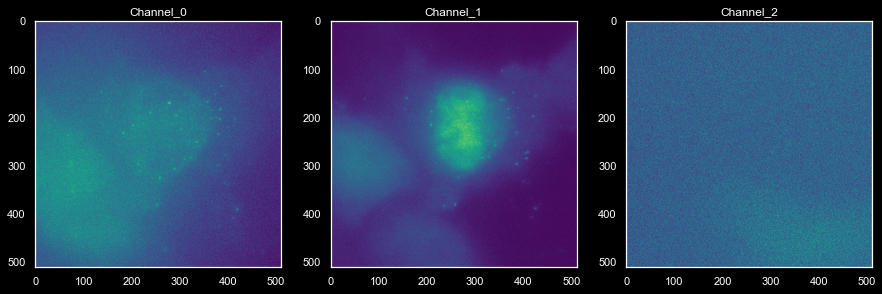

In [6]:
# Plotting original image
selected_time=0
num_channels = img_croparray.shape[5] #3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(15,7))
for i in range(0,num_channels):
    ax[i].imshow(np.max(img_croparray[0,selected_time,:,:,:,i] ,axis=0),cmap='viridis' )
    ax[i].grid(False)
    ax[i].set_title('Channel_'+str(i))

## Max projection and masking


----

In [7]:
#best_zs = [4,10]
img_max = np.max(img_croparray[0,:,:,:,:,1],axis=1)
img_max.shape

(65, 512, 512)

# Segmentation using cellpose

## Segmentation cytosol

Cellpose detcted  3 cytosol masks


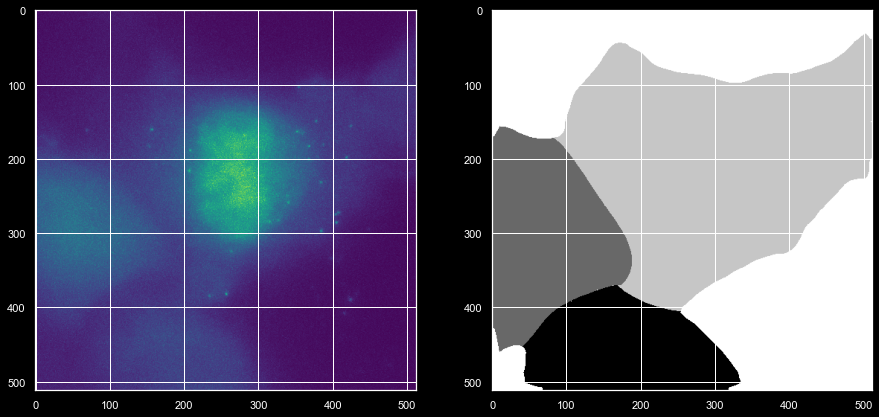

In [8]:
# parameters for cellpose
channels = [0,0]
# Cellpose Model
model = models.Cellpose(gpu=core.use_gpu(), model_type='cyto') # model_type='cyto' or model_type='nuclei'
# Running the models
masks_cyto, flows, styles, diams = model.eval(img_max[selected_time], diameter=cytosol_diameter_size, flow_threshold=None, channels=channels)
print('Cellpose detcted ', str(np.amax(masks_cyto)), 'cytosol masks')

# Plotting
num_col = 2
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(img_max[selected_time],cmap='viridis' )
ax[1].imshow(masks_cyto,cmap='Greys')
plt.show()

## Segmentation nucleus

Cellpose detcted  2 nucleus masks


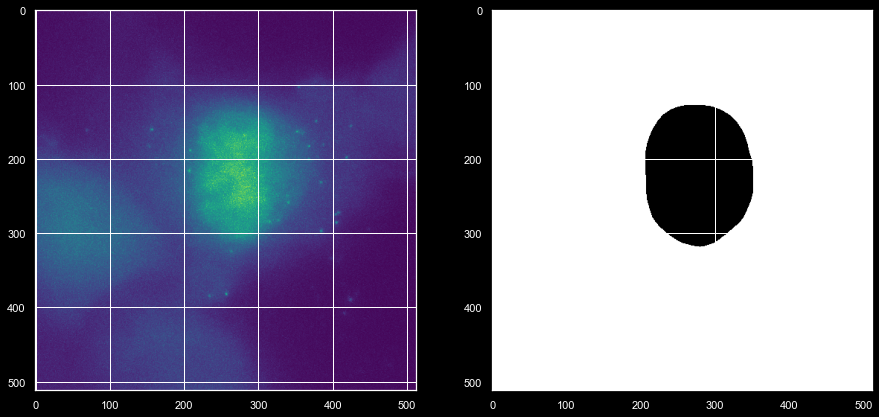

In [9]:
# Cellpose model
model = models.Cellpose(gpu=core.use_gpu(), model_type='nuclei') # model_type='cyto' or model_type='nuclei'
# Running the models
masks_nuc, flows, styles, diams = model.eval(img_max[selected_time], diameter=nulceus_diameter_size, flow_threshold=None, channels=channels)
print('Cellpose detcted ', str(np.amax(masks_nuc)), 'nucleus masks')

# keeping only the largest mask.
num_masks_nuc = np.amax(masks_nuc)
if num_masks_nuc >1:
    masks_nuc_area = [np.count_nonzero(masks_nuc==j) for j in range(1, num_masks_nuc+1)]
    largest_mask = np.argmax(masks_nuc_area) +1   
    masks_nuc =  np.where(masks_nuc == largest_mask, 1, 0) 

# Plotting
num_col = 2
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(img_max[selected_time],cmap='viridis' )
ax[1].imshow(masks_nuc,cmap='Greys')
plt.show()

The following code removes cytosol masks that do not contain a cytosol.

In [10]:
# Keeping only masks with nucleus
def is_nucleus_in_cytosol(mask_n, mask_c):
    ''' This function detects if a cytosol has a nucleus. Returns 1 if true.'''
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> size_mask_n*0.8): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0

In [11]:
# Looking if the mask has a nucleus
number_cytosols = np.amax(masks_cyto)
is_cyto_with_a_nucleus = np.zeros(number_cytosols,dtype='int') # prealocating an array
for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
    masks_cyto_temp =  np.where(masks_cyto == i, 1, 0)
    is_cyto_with_a_nucleus[i-1] = is_nucleus_in_cytosol(masks_nuc, masks_cyto_temp)

# removing cytosol masks without nucleus
masks_cyto_complete = np.zeros_like(masks_cyto) # Prealocating an array to contain the final masks 
counter = 1
for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
    if is_cyto_with_a_nucleus[i-1] == True:
        # Keeping only the masks with a  nucleus
        masks_cyto_complete =  np.where(masks_cyto == i, counter, 0) 
        counter+=1
# cytosol without nucleus
masks_cyto_no_nucleus = masks_cyto_complete - masks_nuc


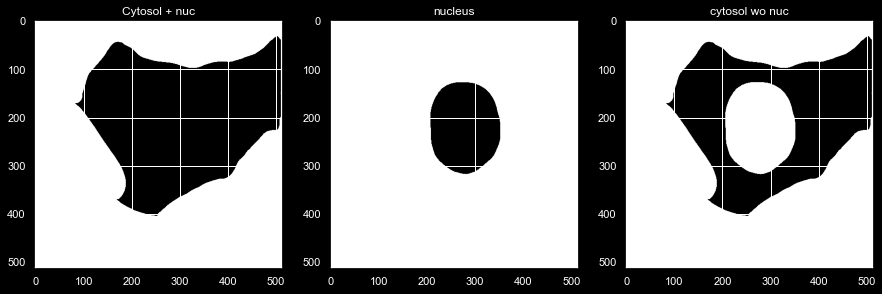

In [12]:
# Plotting
num_col = 3
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(masks_cyto_complete,cmap='Greys' )
ax[0].set_title('Cytosol + nuc')
ax[1].imshow(masks_nuc,cmap='Greys')
ax[1].set_title('nucleus')
ax[2].imshow(masks_cyto_no_nucleus,cmap='Greys')
ax[2].set_title('cytosol wo nuc')
plt.show()


masked image shape (65, 512, 512)


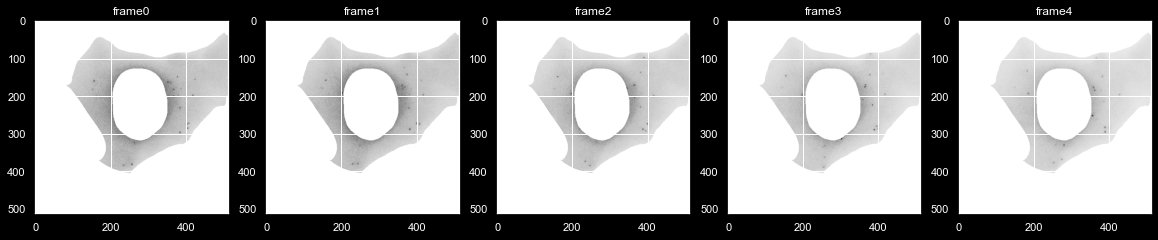

In [13]:
# apply the mask to the complete movie
masked_img = np.multiply(img_max,masks_cyto_no_nucleus)
print('masked image shape', str(masked_img.shape))

# plotting some frames of the masked image
num_col = 5
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(20,7))
for i in range(0,num_col):
    ax[i].imshow(masked_img[i],cmap='Greys')
    ax[i].set_title('frame'+str(i) )
plt.show()

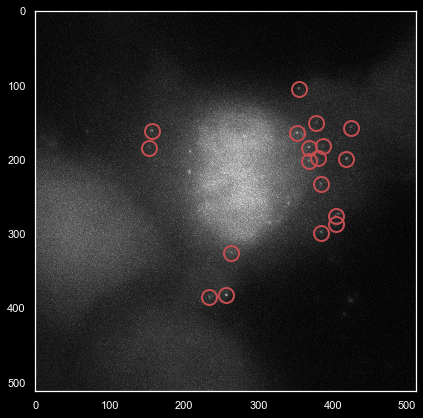

In [14]:
# Finding good settings: 'Detect test' button

# locate spots in a given time
f = tp.locate(img_max[selected_time], particle_diameter,minmass=min_mass_intensity)
coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
coords_int = np.round(coords).astype(int)  # or np.floor, depends
values_at_coords = masks_cyto_no_nucleus[tuple(coords_int.T)] # If 1 the value is in the mask
f['In Mask']=values_at_coords # Check if pts are on/in polygon mask  

# Plotting the spots in the cytosol
plt.figure(figsize=(7, 7))
plt.grid(False)
tp.annotate(f[f['In Mask']==True], img_max[0])
plt.show()

In [15]:
def spots_in_mask(f,mask,label):
    # extracting the contours in the image
    coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    f[label]=values_at_coords # Check if pts are on/in polygon mask  
    return f 

If satisfied, then process the entire movie the same way:

In [16]:
dataframe_directory =  current_dir.joinpath('dataframes')
if not os.path.exists(str(dataframe_directory)):
    os.makedirs(str('dataframes'))

In [17]:
data_frame_file_name =  current_dir.joinpath('dataframes', img_path.stem+'.csv')
f = tp.batch(img_max, diameter=particle_diameter,minmass=min_mass_intensity)
f_list = []
for i in np.arange(len(f['frame'].unique())):
    f0 = f[f['frame']==i]
    f1 = f0.copy()
    # Label points in cell
    f1 = spots_in_mask(f1,masks_cyto_no_nucleus,'In_Cell') 
    # Label points in nucleus
    f1 = spots_in_mask(f1,masks_nuc,'In_Nucleus')
    f_list.append(f1)
f_all = pd.concat(f_list)
f_all.to_csv(data_frame_file_name)
f_all

Frame 64: 52 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,In_Cell,In_Nucleus
0,104.383756,354.094199,3016.260552,1.411941,0.172158,384.756182,37111.0,0.185839,0,1,0
1,146.883482,273.394153,1063.298527,1.731000,0.620303,117.514465,61573.0,0.063353,0,0,1
2,150.116481,377.403554,3001.694683,1.444763,0.112106,360.779282,41582.0,0.137316,0,1,0
3,156.672640,423.989856,2564.293996,1.485771,0.200892,304.076084,38645.0,0.165744,0,1,0
4,160.341277,267.701086,1014.031328,1.510290,0.236987,116.635575,68813.0,0.053012,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4147,344.740211,315.882673,6234.967171,1.462879,0.193018,759.594163,57593.0,0.086242,64,1,0
4148,356.937787,221.067701,7546.427891,1.442398,0.106195,930.818525,65606.0,0.069027,64,1,0
4149,359.213562,292.664770,1552.893462,1.458885,0.136808,190.924751,42062.0,0.166945,64,1,0
4150,360.878737,259.880623,4600.758116,1.476533,0.176288,526.030214,57985.0,0.085203,64,1,0


Convert f to crop_array format

In [18]:
spots = f_all.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp','In_Cell','In_Nucleus']] # keeping signal out of curiousity... want to compare to disk-donut measurements  

In [19]:
spots

,fov,id,f,yc,xc,signal_tp,In_Cell,In_Nucleus
0,0,0,0,104.383756,354.094199,384.756182,1,0
1,0,1,0,146.883482,273.394153,117.514465,0,1
2,0,2,0,150.116481,377.403554,360.779282,1,0
3,0,3,0,156.672640,423.989856,304.076084,1,0
4,0,4,0,160.341277,267.701086,116.635575,0,1
...,...,...,...,...,...,...,...,...
4147,0,4147,64,344.740211,315.882673,759.594163,1,0
4148,0,4148,64,356.937787,221.067701,930.818525,1,0
4149,0,4149,64,359.213562,292.664770,190.924751,1,0
4150,0,4150,64,360.878737,259.880623,526.030214,1,0


## Create Crop Array
____

Create a crop array from 4D movie

In [20]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'], name = img_path)
my_ca

Original video dimensions:  (1, 65, 1, 512, 512, 3)
Padded video dimensions:  (1, 65, 1, 522, 522, 3)
Max # of spots per frame:  84
Shape of numpy array to hold all crop intensity data:  (1, 84, 65, 1, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 84, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 84, 65)


<xarray.Dataset>
Dimensions:     (fov: 1, n: 84, t: 65, z: 1, y: 9, x: 9, ch: 3)
Coordinates:
  * fov         (fov) int64 0
  * n           (n) int16 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * t           (t) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z           (z) int64 0
  * y           (y) int64 -4 -3 -2 -1 0 1 2 3 4
  * x           (x) int64 -4 -3 -2 -1 0 1 2 3 4
  * ch          (ch) int64 0 1 2
Data variables:
    int         (fov, n, t, z, y, x, ch) int64 751 835 544 875 832 ... 0 0 0 0 0
    xc          (fov, n, t, ch) int64 359 359 359 370 370 370 ... 0 0 0 0 0 0
    yc          (fov, n, t, ch) int64 109 109 109 130 130 130 ... 0 0 0 0 0 0
    dx          int64 1
    dy          int64 1
    dz          int64 500
    dt          int64 1
    xy_pad      int64 4
    id          (fov, n, t) float64 0.0 69.0 153.0 226.0 ... 0.0 0.0 0.0 0.0
    signal_tp   (fov, n, t) float64 385.0 144.0 541.0 373.0 ... 0.0 0.0 0.0 0.0
    In_Cell     (fov, n, t) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    In_Nucleus  (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    name:     /Users/luisaguilera/Desktop/croparray/database/20220210_metabol...
    date:     video_date

## Save the crop array
____

In [21]:
#croparray_file_name = os.path.join(img_path.stem+'.nc')
#my_ca.to_netcdf(path=croparray_file_name)


## Quantify signal intensity through time
____

In [22]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

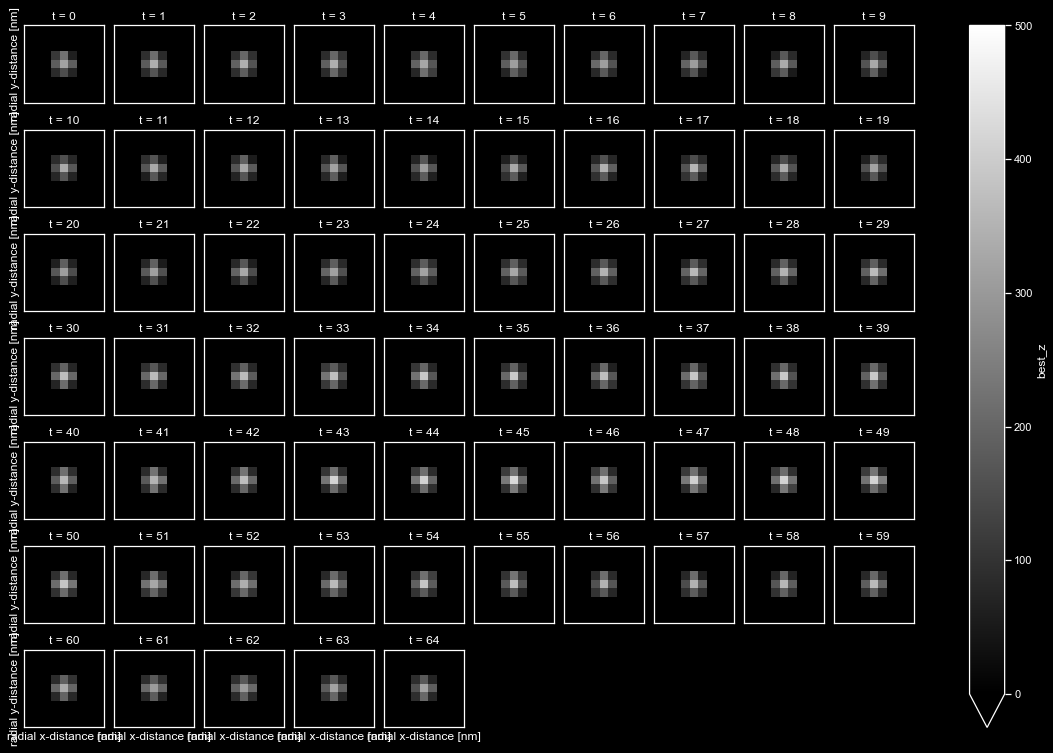

In [23]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =500)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

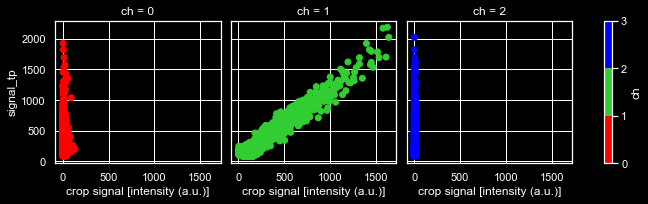

In [24]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

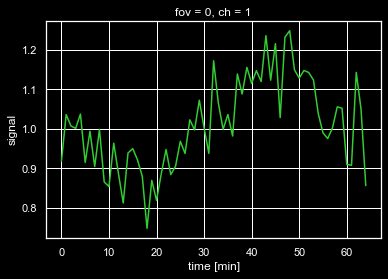

In [25]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

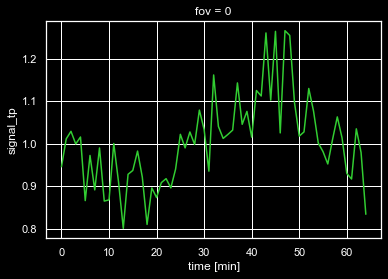

In [26]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [27]:
%gui qt5 
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()

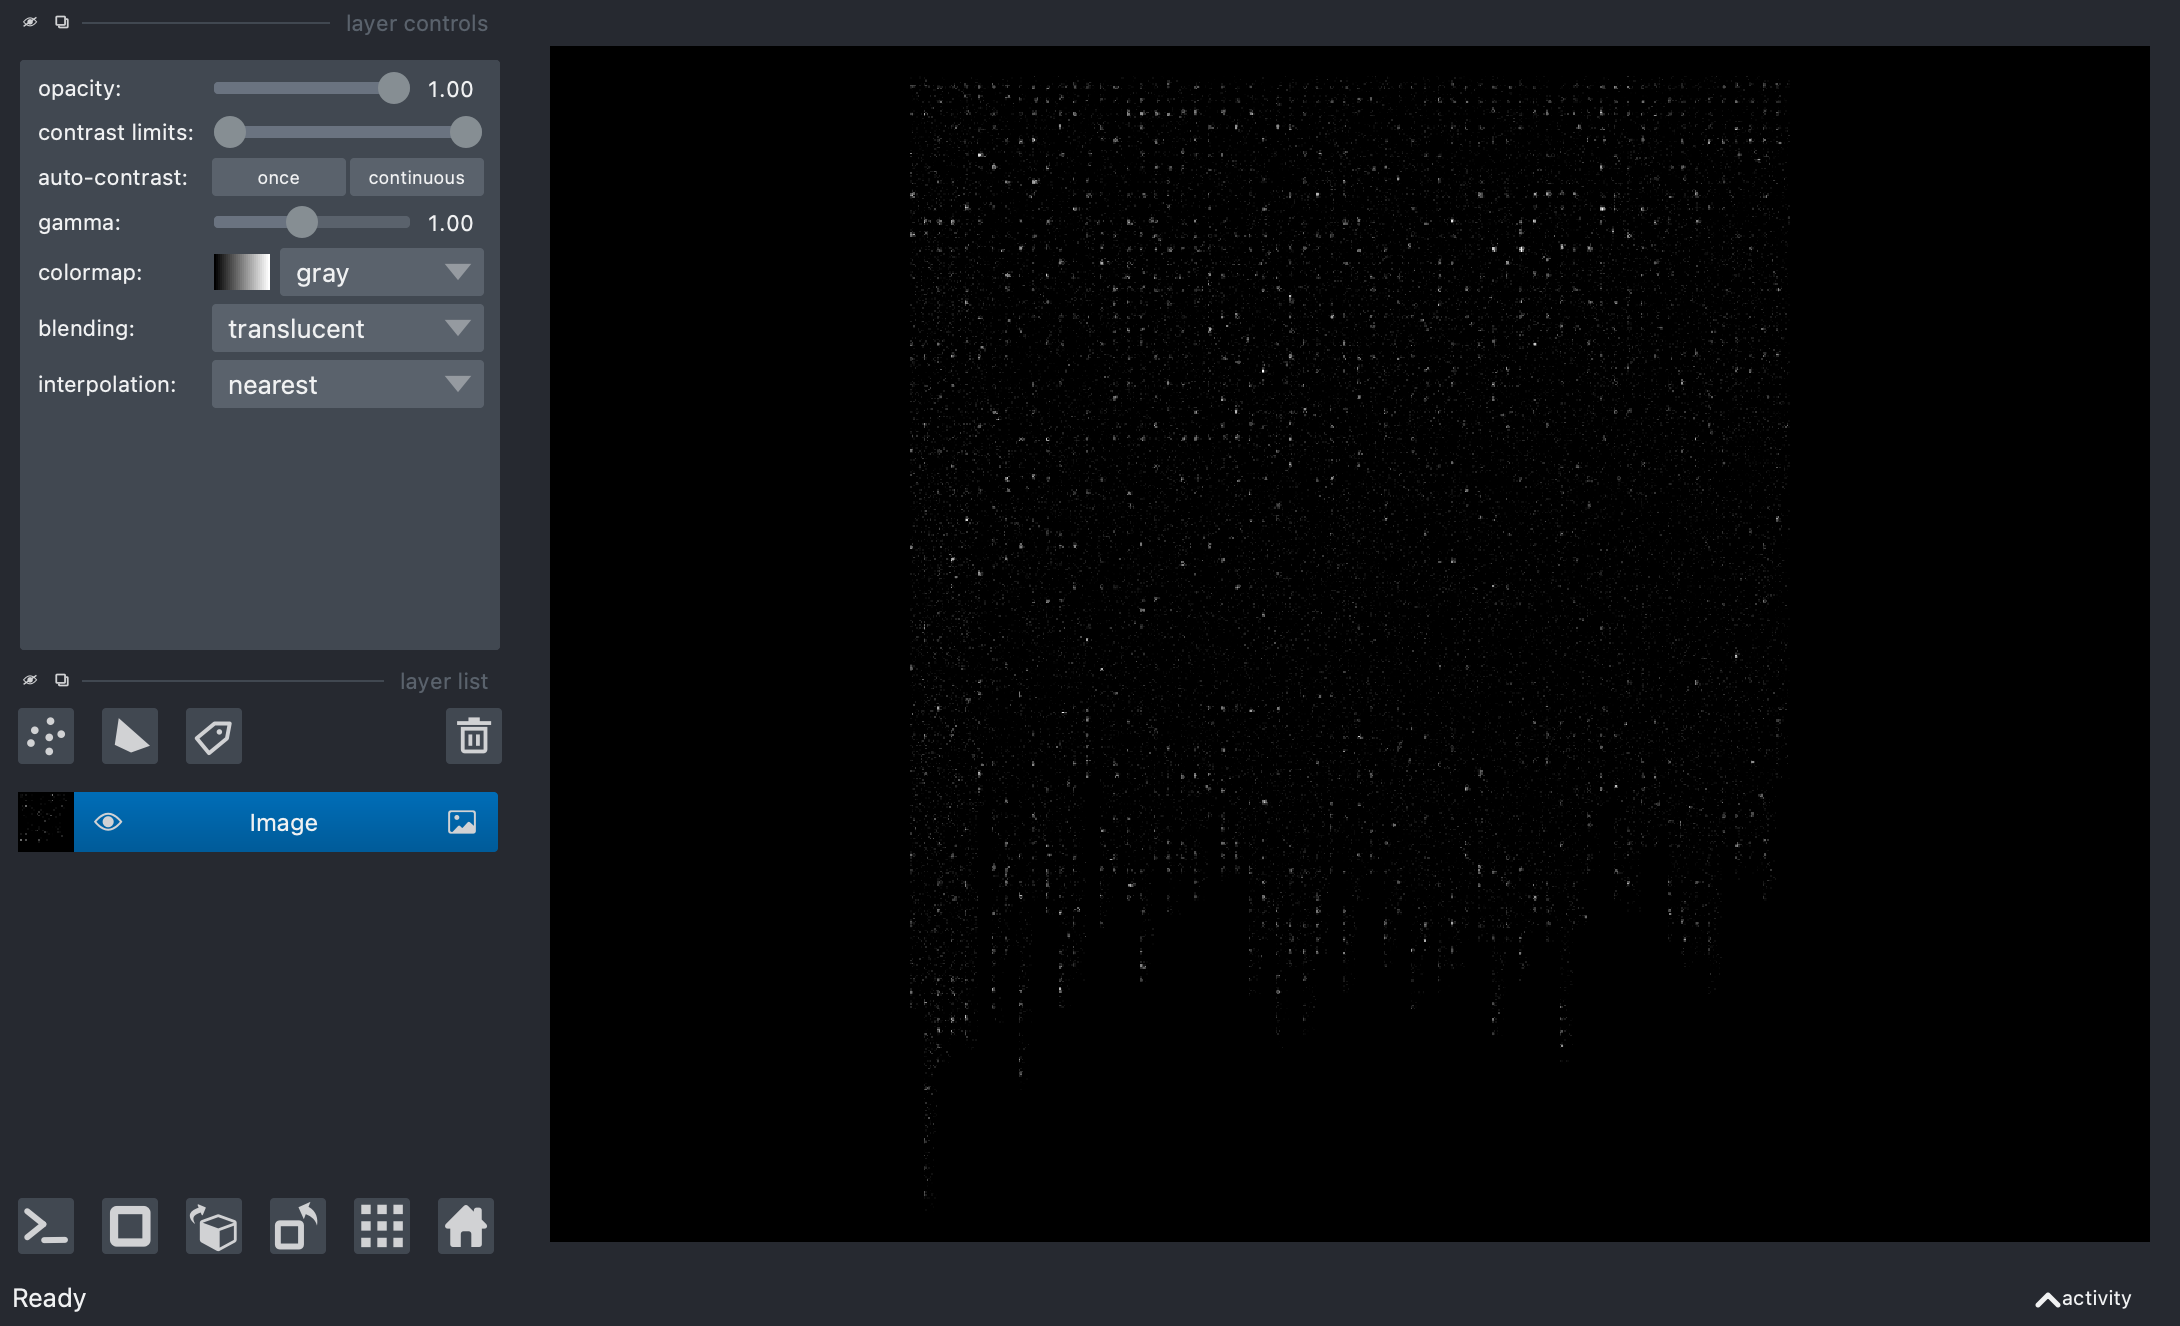

In [28]:
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])
nbscreenshot(viewer)